# Imports

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import torch
import shap

import transformers
from datasets import load_from_disk

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


# Dataset

In [5]:
dataset = load_from_disk("/kaggle/input/erisk25/erisk_processed/erisk_processed")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 25263
    })
    val: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 2807
    })
    test: Dataset({
        features: ['text', 'label', 'user'],
        num_rows: 3115
    })
})

# Model

In [6]:
model_path = '/kaggle/input/disorbert-finetuned-models/pytorch/default/1/finetuned-models/bert-base-cased-finetuned/checkpoint-13430'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)

2025-11-24 19:11:19.855183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764011480.036362      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764011480.088982      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
tokenizer

BertTokenizerFast(name_or_path='/kaggle/input/disorbert-finetuned-models/pytorch/default/1/finetuned-models/bert-base-cased-finetuned/checkpoint-13430', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
pipe = transformers.pipeline('text-classification', model=model, tokenizer=tokenizer, truncation=True, max_length=512, top_k=None, device_map='auto')
pipe

Device set to use cuda:0


In [10]:
explainer = shap.Explainer(pipe)
explainer

In [11]:
test_df = dataset["test"].to_pandas()

# Sample 50 positive and 50 negative
label_1_df = test_df[test_df["label"] == 1].sample(n=50, random_state=42)
label_0_df = test_df[test_df["label"] == 0].sample(n=50, random_state=42)

# Combine
balanced_test_subset = pd.concat([label_1_df, label_0_df]).reset_index(drop=True)

balanced_test_subset = (
    balanced_test_subset.sample(frac=1, random_state=42).reset_index(drop=True)
)

balanced_test_subset.head()

text  label             user
0  nt looking so I have to go out and bag me a co...      0  subject_Fev70kM
1  !!! Honestly found this super helpful. I know ...      0  subject_WAA1iOC
2  enst ,, 1.?,,, 2.? 3.,70w 4., 5. edit: 6., 7.,...      0  subject_y3IiyXk
3   to people in the gaming world... they may kno...      1  subject_z1sGrjq
4   of Clinton because they NEED US to vote for h...      1  subject_eP338bw

In [12]:
test_texts = list(balanced_test_subset['text'])
len(test_texts), test_texts[0]

(100,
 "nt looking so I have to go out and bag me a coed or a cougar or something o scratch that itch but yeah I do nothing and and just sit at home andd not socialize im socially awkward I can't figure out how to talk to people regularly you know but whenever I get that fucking itch I am Rico suave. and you know what when I'm talking to these women I'm faking it I'm faking it you know not orgasm but I'm faking like the social interaction I'm acting basically I act in job interviews I act at work I act in life in general it's fucking bullshit. i camt hold a job either. even with meds i wanna file fkr disability for that reason. I actually took it Autism test the other day for autism ))tests actually and yeah I'm fucking 100% autistic I can't believe it yepbsame here I do nothing at all literally but I just happen to be half as decent looking so I have to go out and bag me a coed or a cougar or something o scratch that itch but yeah I do nothing and and just sit at home andd not sociali

In [13]:
all_shap_values = explainer(test_texts)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 3/100 [00:21<07:34,  4.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [00:28<09:21,  5.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [00:40<12:36,  7.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [00:55<16:32, 10.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [01:07<16:56, 10.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [01:23<13:46,  9.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [01:32<13:46,  9.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [01:44<14:44,  9.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [01:58<16:08, 11.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [02:09<16:14, 11.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [02:20<15:57, 11.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [02:34<12:11,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [02:46<13:15,  9.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [03:01<10:58,  8.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [03:12<12:11,  9.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [03:26<09:57,  7.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [03:35<10:05,  7.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [03:41<09:29,  7.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [03:56<12:13,  9.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [04:04<11:14,  9.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [04:18<12:46, 10.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [04:28<12:36, 10.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [04:35<11:09,  9.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [04:46<11:40, 10.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [04:54<10:41,  9.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [05:05<11:05,  9.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [05:17<11:36, 10.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [05:32<12:55, 11.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [05:41<11:58, 11.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [05:54<12:22, 11.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [06:09<13:13, 12.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [06:29<15:29, 14.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [06:36<12:43, 12.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [06:50<12:47, 12.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [07:01<12:17, 12.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [07:16<12:48, 13.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [07:28<12:09, 12.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [07:39<08:10,  8.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [07:53<09:21, 10.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [08:05<06:50,  7.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [08:23<06:44,  8.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [08:34<07:19,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [08:43<07:10,  8.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [08:50<06:32,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [09:00<06:40,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [09:11<07:09,  9.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [09:30<06:24,  8.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [09:42<06:49,  9.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [10:33<15:13, 22.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [10:47<13:05, 19.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [10:56<10:47, 16.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [11:04<08:48, 13.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [11:14<05:32,  9.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [11:31<04:47,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [12:25<12:05, 21.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [12:39<07:10, 13.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [12:50<06:31, 13.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [13:01<05:59, 12.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [13:10<05:17, 11.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [13:20<03:18,  7.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [13:29<03:24,  8.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [13:41<02:37,  6.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [14:00<03:46, 10.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [14:29<01:33,  5.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [14:43<02:10,  8.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [14:55<02:16,  9.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [15:09<02:31, 10.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [15:15<01:59,  9.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [15:29<02:06, 10.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [15:44<02:10, 11.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [15:58<02:07, 12.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [16:21<00:40,  6.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [16:39<00:50, 10.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [16:46<00:36,  9.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [16:52<00:24,  8.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [17:00<00:16,  8.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [17:12<00:09,  9.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [17:22, 10.42s/it]


In [14]:
for i in range(3):
    shap.plots.text(all_shap_values[i])

In [15]:
def get_global_word_importance(shap_values):

    def to_scalar(v):
        """Convert any SHAP value (scalar, array, tensor) to float."""
        try:
            # If it's already a scalar
            return float(v)
        except Exception:
            # Convert to numpy
            arr = np.array(v)

            if arr.ndim == 0:
                return float(arr)

            if arr.ndim == 1 and len(arr) == 1:
                return float(arr[0])

            # Multi-output: sum contributions
            return float(arr.sum())

    global_stats = {}

    for explanation in shap_values:
        tokens = explanation.data
        values = explanation.values

        for token, val in zip(tokens, values):

            # Convert tokens to string
            token = str(token).replace("##", "").strip()

            # Skip noise tokens
            if token in ["", "[CLS]", "[SEP]", "[PAD]"]:
                continue

            # Convert SHAP value to scalar
            val = to_scalar(val)

            # Update word-level stats
            if token not in global_stats:
                global_stats[token] = {"sum": 0.0, "count": 0}

            global_stats[token]["sum"] += val
            global_stats[token]["count"] += 1

    

    # Convert to DataFrame
    threshold = 5
    df = pd.DataFrame([
        {
            "Word": word,
            "Total_SHAP_Impact": stats["sum"],
            "Frequency": stats["count"],
            "Average_Attribution": (stats["sum"] / stats["count"]) if stats['count'] > threshold else 0
        }
        for word, stats in global_stats.items()
    ])

    return df

In [16]:
df_importance = get_global_word_importance(all_shap_values)
df_importance = df_importance.sort_values("Average_Attribution", ascending=False)

In [17]:
def clean_word(token_list_string):
    words = re.findall(r"[A-Za-z]+", token_list_string)
    return words[0] if words else ""  

In [18]:
df_importance["Clean_Word"] = df_importance["Word"].apply(clean_word)

top_depression_words = (
    df_importance.sort_values(by="Average_Attribution", ascending=False)
    .head(20)
)

print("\nTop Words Driving Depression Prediction:")
print(top_depression_words[["Clean_Word", "Average_Attribution", "Frequency"]])


Top Words Driving Depression Prediction:
     Clean_Word  Average_Attribution  Frequency
2545         hi         1.802415e-09         12
743        love         1.588208e-09         30
824                     1.575062e-09          6
1358        Why         1.446647e-09         11
4551      armor         1.335463e-09          9
1031      start         1.333886e-09         33
2461         br         1.210642e-09          6
1776         os         1.180072e-09         12
4197         Al         1.059219e-09          6
1702        con         9.642421e-10         22
4871         za         9.031481e-10          6
1098     inside         8.291233e-10         12
3993      brand         7.508055e-10          6
1494       fire         5.501697e-10         11
1757       Does         5.270839e-10          6
1645         sa         5.023472e-10         18
2778         ok         4.980851e-10          6
2032     Always         4.485841e-10          6
1344       Nice         4.407979e-10          

In [19]:
def plot_global_importance(df, title, color_palette='Reds_r'):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))

    # Sort by SHAP value
    df = df.sort_values("Average_Attribution")

    # Plot ONLY the bar chart
    sns.barplot(
        data=df,
        x="Average_Attribution",
        y="Clean_Word",
        palette=color_palette
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Average_Attribution")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

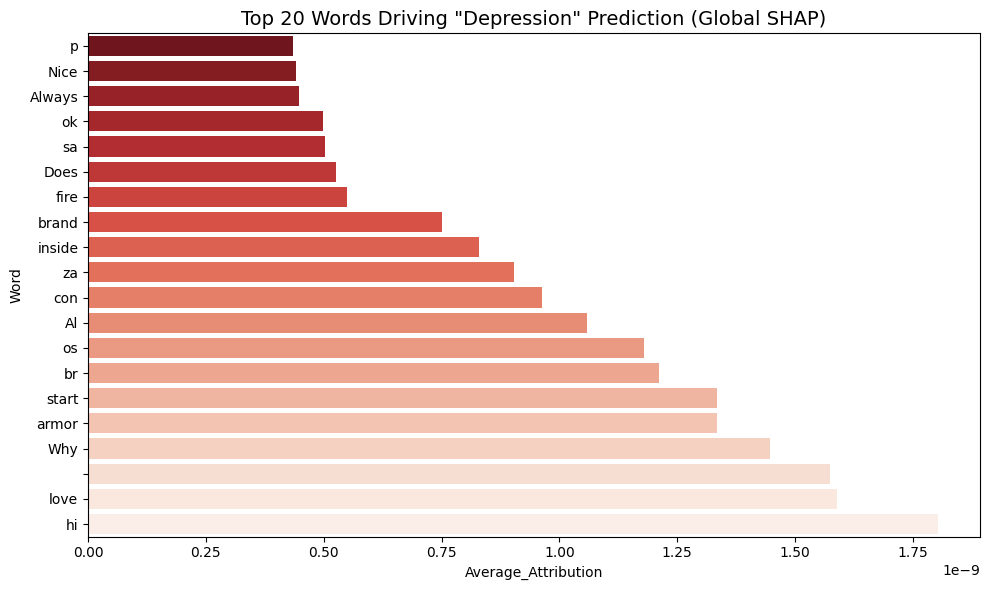

In [20]:
plot_global_importance(
    top_depression_words,
    title='Top 20 Words Driving "Depression" Prediction (Global SHAP)',
    color_palette='Reds_r'
)
